# 02477 Exercise 12: Black-box variational inference

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import seaborn as snb

from time import time

from jax import grad, value_and_grad
from jax.scipy.stats import norm

from exercise12 import create_linear_regression_data
from exercise12 import AdamOptimizer

# relevant distributions
npdf = lambda x, m, v: jnp.exp(-(x-m)**2/(2*v))/jnp.sqrt(2*jnp.pi*v)
log_npdf = lambda x, m, v: -(x-m)**2/(2*v) - 0.5*jnp.log(2*jnp.pi*v)

# plotting stuff
snb.set_style('darkgrid')
snb.set_theme(font_scale=1.25)
colors = snb.color_palette()

### Overview

The purpose of this exercise is to study and become familiar with **black-box variational inference (BBVI)**, which combines a large proportion of the theory we discussed through the course.



**Content**

- Part 1: Kullback-leibler divergences and mean-field variational families
- Part 2: Black-box variational inference theory
- Part 3: Variational Inference for a linear Gaussian model
- Part 4: Black-box variational inference (BBVI) for the Linear Gaussian model
- Part 5: Spam vs ham detection
- Part 6: Prototyping and testing models using BBVI



**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.

**Note**: If you find yourself spending more than 30minutes on a single task, consider asking for help or look up at the solution for inspiration and move forward.


In part 1, we will the combination of mean-field families with the  KL[q||p]  divergence. In part 2, we will review the basic theory of BBVI. To understand the properties of BBVI, we will compare BBVI to classic VI using a linear Gaussian system. Part 3 deals with the classic variational approximation to the linear Gaussian system and part 4 deals with BBVI counterpart. Finally, in part 5+6 we will build a simple text classifier for SPAM detection. We will see how to use BBVI to rapidly comparing and testing different models for binary classification.


---



# Part 1:  Kullback-leibler divergences and mean-field variational families

Before diving into the black-box variational inference algorithm, we will first study the combination of variational inference using $\text{KL}[q||p]$ with mean-field Gaussian families. For the purpose of this analysis, we will assume our target distribution $p$ is a multivariate Gaussian distribution

$$\begin{align*}
p(\mathbf{w}|\mathbf{y}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{V}),
\end{align*}$$

where $\mathbf{w} \in \mathbb{R}^D$ and $\mathbf{m} \in \mathbb{R}^D$ is the mean vector and $\mathbf{V} \in \mathbb{R}^{D \times D}$ covariance matrix. Assuming a mean-field Gaussian family, the variational family $\mathcal{Q}$ is then the collection of distributions of the form

$$\begin{align*}
q(\mathbf{w}) = \prod_{i=1}^D \mathcal{N}(\mathbf{w}|m_i, v_i) = \mathcal{N}(\mathbf{w}|\hat{\mathbf{m}}, \hat{\mathbf{V}}),
\end{align*}$$

where $\hat{\mathbf{V}}$ is a **diagonal matrix** with elements $\hat{\mathbf{V}}_{ii} = v_i > 0$ and $\hat{\mathbf{V}}_{ij} = 0$ for $i \neq j$.



**Task 1.1**: Does the target distribution $p(\mathbf{w}|\mathbf{y})$ belong to the variational family? Why/why not?

**Solution**

The target distribution $p(\mathbf{w}|\mathbf{y})$ does generally **not** belong to the variational family $\mathcal{Q}$, because we have restricted $\mathcal{Q}$ to be the set of Gaussians with diagonal covariance matrix and $\mathbf{V}$ is generally non-diagonal.

**End of solution**


We will now study the optimal approximation $q^*$ in this set-up. More specifically, we are interested in the qualitative behavior of the estimated variances for $q^*$ given by

$$\begin{align*}
q^* = \arg\min_{q\in \mathcal{Q}}\text{KL}[q(\mathbf{w})||p(\mathbf{w}|\mathbf{y})]
\end{align*}$$

where $\text{KL}[q(\mathbf{w})||p(\mathbf{w}|\mathbf{y})]$-divergence, which can be computed analytically for multivariate Gaussians:

$$\begin{align*}
\text{KL}[q||p] = \frac12 \left[\text{trace}\left(\mathbf{V}^{-1}\hat{\mathbf{V}}\right) + \left(\textbf{m}- \hat{\textbf{m}}\right)^T\mathbf{V}^{-1} \left(\textbf{m}- \hat{\textbf{m}}\right) - D  + \log \frac{|\mathbf{V}^{-1}|}{|\hat{\mathbf{V}}|}\right],
\end{align*}$$

where $D > 0$ is the dimension of $\mathbf{w}$.

Inspecting the equation above, we can see that the solution for the variational mean is given by $\hat{\mathbf{m}} = \mathbf{m}$. The focus of this exercise is to study the variances and therefore, we will simplify the problem by assuming $\hat{\textbf{m}} = \textbf{m} = 0$:

$$\begin{align*}
\text{KL}[q(\mathbf{w})||p(\mathbf{w}|\mathbf{y})] = \frac12 \left[\text{trace}\left(\mathbf{V}^{-1}\hat{\mathbf{V}}\right) - D  + \log \frac{|\mathbf{V}^{-1}|}{|\hat{\mathbf{V}}|}\right] \tag{A}.
\end{align*}$$

We don't need this assumption to carry out our analysis, but it is merely to limit the required work for the exercise. Next, we will compute the matrix derivative of eq. (A) with respect to $\hat{\mathbf{V}}$.






To do this, you will need the following results from matrix calculus (see e.g [The Matrix Cookbook](https://www2.imm.dtu.dk/pubdb/edoc/imm3274.pdf) or Section 7.8  in Murphy1)

- For matrix $\mathbf{A}$ and $\mathbf{D}$, where $\mathbf{D}$ is diagonal, we have $\frac{\partial \text{trace}(\mathbf{A}\mathbf{D})}{\partial \mathbf{D}_{ii}} = \mathbf{A}_{ii}$ 


- The derivative of the log determinant of a **diagonal matrix** $\mathbf{D}$ is given by $\frac{\partial \log |\mathbf{D}|}{\partial \mathbf{D}_{ii}} = \frac{1}{\mathbf{D}_{ii}}$ 



**Task 1.2**: Show that the optimal value for $\hat{\mathbf{V}}_{ii}$ in this set-up is given by $\hat{\mathbf{V}}_{ii} = \frac{1}{(\mathbf{V}^{-1})_{ii} }$

*Hints:  Compute the derivative of eq. (A), equate it to zero and solve for $\hat{\mathbf{V}}_{ii}$.*

**Solution**

We have

$$\begin{align*}
\frac{\partial}{\partial \hat{V}_{ii}}\text{KL}[q||p] &= \frac{\partial}{\partial \hat{V}_{ii}}\frac12 \left[\text{trace}\left(\mathbf{V}^{-1}\hat{\mathbf{V}}\right) - D  + \log \frac{|\mathbf{V}^{-1}|}{|\hat{\mathbf{V}}|}\right]\\
%
&= \frac12 \frac{\partial}{\partial \hat{V}_{ii}} \text{trace}\left(\mathbf{V}^{-1}\hat{\mathbf{V}}\right)+ \frac12\frac{\partial}{\partial \hat{V}_{ii}}  \log \frac{|\mathbf{V}^{-1}|}{|\hat{\mathbf{V}}|}\\
%
&= \frac12 \frac{\partial}{\partial \hat{V}_{ii}} \text{trace}\left(\mathbf{V}^{-1}\hat{\mathbf{V}}\right)+ \frac12\frac{\partial}{\partial \hat{V}_{ii}}  \left[ \log |\mathbf{V}^{-1}| - \log |\hat{\mathbf{V}}|\right]\\
%
&= \frac12 \frac{\partial}{\partial \hat{V}_{ii}} \text{trace}\left(\mathbf{V}^{-1}\hat{\mathbf{V}}\right) - \frac12\frac{\partial}{\partial \hat{V}_{ii}}  \log |\hat{\mathbf{V}}|\\
\end{align*}$$

Using the results above yields
$$\begin{align*}
\frac{\partial}{\partial \hat{V}_{ii}}\text{KL}[q||p]&= \frac12 (\mathbf{V}^{-1})_{ii}   -\frac12\frac{1}{\hat{\mathbf{V}_{ii}}}
\end{align*}$$

Equating to zero and solving for $\hat{\mathbf{V}_{ii}}$ yields

$$\begin{align*}
\frac12 (\mathbf{V}^{-1})_{ii}   -\frac12\frac{1}{\hat{\mathbf{V}_{ii}}} = 0 \quad\quad\iff \quad\quad   (\mathbf{V}^{-1})_{ii}   - \frac{1}{\hat{\mathbf{V}_{ii}}} = 0 \quad\quad\iff \quad\quad \hat{\mathbf{V}}_{ii} = \frac{1}{(\mathbf{V}^{-1})_{ii} }
\end{align*}$$




**End of solution**

Next, assume $\mathbf{V} = \begin{bmatrix} 1 & \rho \\ \rho & 1\end{bmatrix}$ for $\rho \in \left(-1, 1\right)$ such that $\rho$ controls the correlation of the target distribution.

**Task 1.3**: Compute and plot  $\mathbf{V}_{11}$ and $\hat{\textbf{V}}_{11}$ as a function of the correlation coefficient $\rho \in \left(-1, 1\right)$. How well does the mean-field approximation capture the correlation of the target distribution? How well does the mean-field approximation capture the marginal variances of the target distribution?

**Solution**


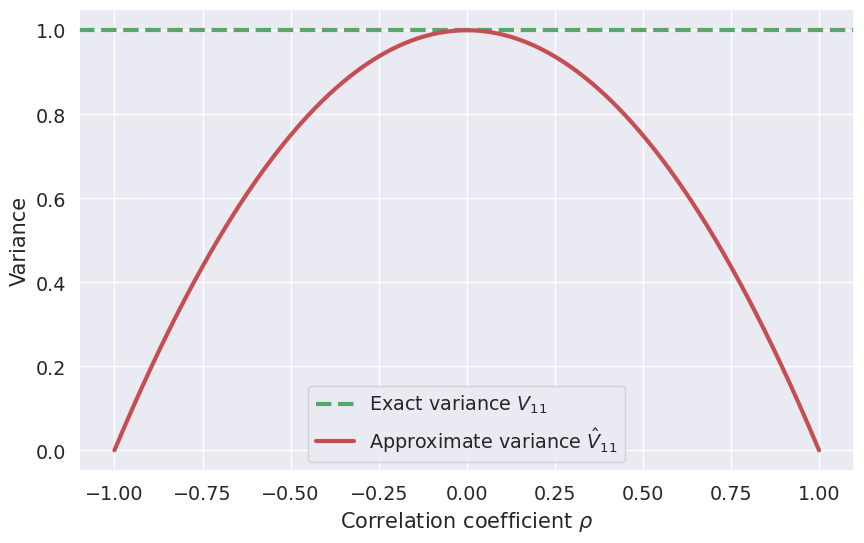

In [2]:
rho_grid = jnp.linspace(-1+1e-6, 1-1e-6, 1000)

# V_11 is always one by construction
V11 = 1

# Compute hat{V}_11
Vhat_11 = []
for rho in rho_grid:
     V = jnp.array([[1, rho], [rho, 1]])
     V_inv = jnp.linalg.inv(V)
     Vhat_11.append(1/V_inv[0,0])

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.axhline(V11, label='Exact variance $V_{11}$', color='g', linestyle='--', linewidth=3)
ax.plot(rho_grid, Vhat_11, color='r', label='Approximate variance $\\hat{V}_{11}$', linewidth=3)
ax.legend()
ax.set(xlabel='Correlation coefficient $\\rho$', ylabel='Variance');



Mean-field families cannot capture the correlation structure of the target distribution by construction. And from this experiment, we can easily see that the mean-field approximation underestimates the marginal variances more and more as the correlation of the target distribution becomes stronger.


**End of solution**


---


## Part 2:  Black-box variational inference theory

For the rest of the exercise, we will focus on the **black-box variational inference (BBVI)** algorithm. Recall, the goal of variational inference is to find the best approximation $q \in \mathcal{Q}$ in a given variational family $\mathcal{Q}$ by minimizing the KL divergence $\text{KL}[q||p]$ between the approximation $q$ and the target distribution $p$. In practice, we do this by maximizing the so-called evidence lower bound (ELBO) given by


\begin{align*}
\mathcal{L}\left[q\right] = \mathbb{E}_{q(\mathbf{w})}\left[\log p(\mathbf{y}, \mathbf{w})\right] - \mathbb{E}_{q(\mathbf{w})}\left[\log q(\mathbf{w})\right]\tag{1},
\end{align*}


where $p(\mathbf{y}, \mathbf{w}) = p(\mathbf{y}|\mathbf{w})p(\mathbf{w})$ is the joint distribution of the observations $\mathbf{y}$ and the parameters $\mathbf{w}$.

In this exercise, we will use the set of **mean-field Gaussians** as the variational family, i.e.

\begin{align*}
q(\mathbf{w}) = \prod_{i=1}^D \mathcal{N}(w_i|m_i, v_i) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{V}), \tag{2}
\end{align*}


where $\mathbf{V}$ is a diagonal matrix and $\lambda = \left\lbrace \mathbf{m}, \mathbf{V}\right\rbrace$ are the **variational parameters**. With this choice of variational family, the **entropy term** in eq. (1) can be computed analytically (which you will derive in assignment #3)


\begin{align*}
\mathcal{H}\left[q\right] = -\mathbb{E}_{q(\mathbf{w})}\left[\log q(\mathbf{w})\right] = \frac12\sum_{i=1}^D \log (2\text{e}\pi v_i). \tag{3}
\end{align*}

In classic variational inference, we compute the expectation of the log joint distribution in eq. (1) analytically. However, not all distributions exhibit analytical solutions to these expectations and therefore, this limits the set of distributions we can use. Furthermore, every time we change a component of the model, we have to re-derive these expectations, which makes prototyping many different models a very time-consuming process. 

In BBVI, the expectation of the log joint density is estimated using Monte Carlo sampling. That is,
\begin{align*}
\mathbb{E}_{q(\mathbf{w})}\left[\log p(\mathbf{y}, \mathbf{w})\right] \approx \frac{1}{S}\sum_{s=1}^S \log p(\mathbf{y}, \mathbf{w}^s), \tag{4}
\end{align*}


where $\mathbf{w}^s \sim q(\mathbf{w})$ are samples from the approximate posterior $q$ and $S$ is the number of Monte Carlo samples. Consequently, we can apply VI to a much larger set of models and distributions and we no longer have derive the expected values by hand everytime we want to test a new model. The price we pay for this flexibility is that our objective function and its gradients becomes **stochastic**.

In this exercise, we will focus on the broad class of models, where the observations $\mathbf{y}$ can be assumed **conditionally independent** given $\mathbf{w}$. That is,
\begin{align*}
p(\mathbf{y}, \mathbf{w}) = \prod_{n=1}^N p(y_n|\mathbf{w})p(\mathbf{w}) \tag{5}
\end{align*}

This class of models includes linear regression, logistic regression, multiclass classification, neural networks, Gaussian processes etc. Substituting this decomposition into eq. (4) yields
\begin{align*}
\mathbb{E}_{q(\mathbf{w})}\left[\log p(\mathbf{y}, \mathbf{w})\right] \approx \frac{1}{S}\sum_{s=1}^S \sum_{n=1}^N \log  p(y_n|\mathbf{w}^s) + \frac{1}{S}\sum_{s=1}^S \log p(\mathbf{w}^s) \tag{6}
\end{align*}


For large datasets, this can be prohibitively slow since we need to evaluate $N$ expectations in every single iteration. To alleviate this, we will use **minibatching** and further approximate eq. (6) as follows

$$
\begin{align*}
\mathbb{E}_{q(\mathbf{w})}\left[\log p(\mathbf{y}, \mathbf{w})\right]  \approx \frac{1}{S}\frac{N}{M}\sum_{s=1}^S \sum_{n \in \mathcal{M}} \log  p(y_n|\mathbf{w}^s) + \frac{1}{S}\sum_{s=1}^S \log p(\mathbf{w}^s), \tag{7}
\end{align*}
$$

where $\mathcal{M}$ denotes a random subset of the data with **batch size** $M = |\mathcal{M}|$. Using this approximation, we only have to evaluate $M \ll N$ terms in each iteration and if we resample $\mathcal{M}$ in every iteration, then eq. (7) is an **unbiased** estimator of $\mathbb{E}_{q(\mathbf{w})}\left[\log p(\mathbf{y}, \mathbf{w})\right]$.

In this exercise, we will use the **re-parametrization trick** for estimating the gradients of the form

$$\begin{align*}
\nabla_{\mathbf{\lambda}} \mathbb{E}_{q_{\mathbf{\lambda}}(\mathbf{w})} \! \left[    \log  p(\mathbf{y},\mathbf{w})\right] \approx \frac{1}{S} \sum_{s=1}^S  \nabla_{\mathbf{\lambda}}  \log  p(\mathbf{y}, \mathbf{w}_{\epsilon_s}),
\end{align*}$$
where $\mathbf{w}_{\epsilon_s} = \mathbf{m} + \mathbf{L}\mathbf{\epsilon}_{s}$ and $\mathbf{\epsilon}_{s} \sim q(\mathbf{\epsilon})=\mathcal{N}(\mathbf{\epsilon}|\mathbf{0}, \mathbf{I})$. Because of the mean-field assumption and the diagonal nature of $\mathbf{V}$, we do not need to bother computing the Cholesky decomposition $\mathbf{L}$ for $\mathbf{V}$. Instead, let $\mathbf{s}\in \mathbb{R}^D$ contain the standard deviations of the variational approximation, i.e. $\mathbf{s}_i = \mathbf{v}_i^{\frac12}$, then
$$\begin{align*}
\mathbf{w}_{\epsilon_s} = \mathbf{m} + \mathbf{s} \circ \epsilon_s,
\end{align*}$$
where $\circ$ means element-wise multiplication. Finally, we will use the **Adam** optimizer for optimization.

**Task 2.1**: Explain to your neighbor why we need the re-parametrization trick in the first place, i.e. what is the problem with computing $\nabla_{\mathbf{\lambda}} \mathbb{E}_{q_{\mathbf{\lambda}}(\mathbf{w})} \! \left[    \log  p(\mathbf{y},\mathbf{w})\right]$ directly? [**Discussion question**]

---




## Part 3:  Variational Inference for a linear Gaussian model

To understand the behaviour of BBVI, we will first study the posterior distribution of a linear Gaussian model, because this allows us to:

1) compute the exact posterior (using theory from week 3)
2) compute the variational approximation using analytical ELBO (using theory from week 10 & 11)
3) compute the variational approximation using the BBVI ELBO

and compare the results. 

For a linear Gaussian model with observations $\mathbf{y}$, design matrix $\mathbf{X}$, and parameters $\mathbf{w}$, the joint distribution of the model is given by
\begin{align}
p(\mathbf{y}, \mathbf{w}) = \mathcal{N}(\mathbf{y}|\mathbf{X}\mathbf{w}, \sigma^2 \mathbf{I})\mathcal{N}(\mathbf{w}|\mathbf{0}, \kappa^2 \mathbf{I}), \tag{8}.
\end{align}

where the **exact posterior** for $\mathbf{w}$ given $\mathbf{y}$ is given by

\begin{align*}
p(\mathbf{w}|\mathbf{y}) = \mathcal{N}\left(\mathbf{w}|\mathbf{m}, \mathbf{\Sigma}\right),
\end{align*}

where

\begin{align*}
\mathbf{\Sigma}^{-1} &= \frac{1}{\kappa^2} \mathbf{I} + \frac{1}{\sigma^2} \mathbf{X}^T \mathbf{X}\\
\mathbf{m} &= \frac{1}{\sigma^2} \mathbf{\Sigma} \mathbf{X} \mathbf{y}.
\end{align*}

Hence, this will be our gold standard for comparison when using BBVI.




### Calculating the analytical ELBO

 Before setting up the BBVI approximation, we will first derive an analytical **fixed-form** variational approximation for comparison. To do this, we have to calculate the lower bound. We only have to compute the first term in eq. (1) since we already know the entropy term. 



Substituting eq. (8) into the first term in eq. (1) yields
$$\begin{align*}
\mathbb{E}_q\left[\log p(\mathbf{y}, \mathbf{w})\right] &= \mathbb{E}_q\left[\log \prod_{n=1}^N \mathcal{N}(y_n|\mathbf{w}^T\mathbf{x}_n, \sigma^2) \mathcal{N}(\mathbf{w}|\mathbf{0}, \kappa^2 \mathbf{I})\right]
%
= \sum_{n=1}^N \mathbb{E}_q\left[\log  \mathcal{N}(y_n|\mathbf{w}^T\mathbf{x}_n, \sigma^2)\right]+
\mathbb{E}_q\left[\log\mathcal{N}(\mathbf{w}|\mathbf{0}, \kappa^2 \mathbf{I})\right] \tag{9}
\end{align*}$$

Each term in the sum evaluates to

$$\begin{align*}
\mathbb{E}_q\left[\log  \mathcal{N}(y_n|\mathbf{w}^T\mathbf{x}_n, \sigma^2)\right] &= \mathbb{E}_q\left[- \frac{1}{2} \log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\left(y_n - \mathbf{w}^T \mathbf{x}_n\right)^2\right]
%
=  - \frac{1}{2} \log(2\pi\sigma^2) -\frac{1}{2\sigma^2} \mathbb{E}_q\left[y_n^2 + (\mathbf{w}^T \mathbf{x}_n)^2 - 2y_n \mathbf{w}^T \mathbf{x}_n\right]\tag{10}
\end{align*}$$


We can re-write the quadratic term as follows
$$\begin{align*}
(\mathbf{w}^T \mathbf{x}_n)^2 = \left(\sum_{i=1}^D w_i x_{ni}\right)^2 =  \sum_{i=1}^D \sum_{j=1}^D w_ix_{ni} w_j x_{nj} \tag{11}
\end{align*}$$


Substituting back yields
$$\begin{align*}
\mathbb{E}_q\left[\log  \mathcal{N}(y_n|\mathbf{w}^T\mathbf{x}_n, \sigma^2)\right] &= - \frac{1}{2} \log(2\pi\sigma^2) -\frac{1}{2\sigma^2} y_n^2 - \frac{1}{2\sigma^2} \sum_{i=1}^D \sum_{j=1}^D \mathbb{E}_q\left[w_i w_j\right] x_{ni}  x_{nj} +  \frac{y_n}{\sigma^2} \mathbb{E}_q\left[\mathbf{w}^T\right] \mathbf{x}_n\\
%
 &\stackrel{(a)}{=}- \frac{1}{2} \log(2\pi\sigma^2) -\frac{1}{2\sigma^2} y_n^2 - \frac{1}{2\sigma^2} \sum_{i=1}^D \sum_{j=1}^D m_i m_j x_{ni}  x_{nj}  - \frac{1}{2\sigma^2} \sum_{j=i}^D v_i x^2_{ni} +  \frac{y_n}{\sigma^2} \mathbf{m}^T \mathbf{x}_n\\
 %
 &=- \frac{1}{2} \log(2\pi\sigma^2) -\frac{1}{2\sigma^2} y_n^2 - \frac{1}{2\sigma^2} (\mathbf{m}^T \mathbf{x}_n)^2  - \frac{1}{2\sigma^2} \sum_{j=i}^D v_i x^2_{ni} +  \frac{y_n}{\sigma^2} \mathbf{m}^T \mathbf{x}_n\\
%
&= \log \mathcal{N}(y_n|\mathbf{m}^T \mathbf{x}_n, \sigma^2) - \frac{1}{2\sigma^2}  \sum_{i=1}^D v_i x^2_{ni} \tag{12}, 
\end{align*}$$


where we have used the mean-field assumption in $(a)$, i.e. $\mathbb{E}_q\left[w_i w_j\right] = \mathbb{E}_{q(w_i)}\left[w_i\right]\mathbb{E}_{q(w_j)}\left[ w_j\right] = m_i m_j$ for $i \neq j$ and $\mathbb{E}_q\left[w_i^2\right] = m_i^2 + v_i$ for $i = j$ such that:
$$\begin{align*}
\sum_{i=1}^D \sum_{j=1}^D \mathbb{E}_q\left[w_i w_j\right] x_{ni}  x_{nj} &= \sum_{i=1}^D \sum_{j \neq i} \mathbb{E}_q\left[w_i w_j\right] x_{ni}  x_{nj} + \sum_{i=1}^D \mathbb{E}_q\left[w_i^2\right] x_{ni}^2\\
&= \sum_{i=1}^D \sum_{j \neq i} m_i m_j x_{ni}  x_{nj} + \sum_{i=1}^D \left[m_i^2 + v_i\right] x_{ni}^2 \\
&= \sum_{i=1}^D \sum_{j=1}^D m_i m_j x_{ni}  x_{nj} + \sum_{i=1}^D v_i x_{ni}^2
\end{align*}$$

 Don't hesitate to ask for help if some steps are unclear.


A similar line of calculations yields the expectation for the log prior:
\begin{align*}
\mathbb{E}_q\left[\ln\mathcal{N}(\mathbf{w}|\mathbf{0}, \kappa^2 \mathbf{I})\right] &= \sum_{i=1}^D \ln \mathcal{N}(m_i|0, \kappa^2) - \frac{1}{2\kappa^2} \sum_{i=1}^D v_i \tag{13}
\end{align*}


Thus, we can now substitute the results from eq. (3), (12), and (13) to compute the analytical ELBO:
\begin{align}
\mathcal{L}\left[q\right]  = \underbrace{\sum_{n=1}^N \ln \mathcal{N}(y_n|\mathbf{m}^T \mathbf{x}_n, \sigma^2)  -  \frac{1}{2\sigma^2}  \sum_{i=1}^D \sum_{n=1}^N v_i x^2_{ni}}_{\text{expected log likelihood}} + \underbrace{\sum_{i=1}^D \ln \mathcal{N}(m_i|0, \kappa^2) - \frac{1}{2\kappa^2} \sum_{i=1}^D v_i}_{\text{expected log prior}} + \underbrace{\frac12\sum_{i=1}^D \ln (2\text{e}\pi v_i)}_{\text{entropy}} \tag{14}
\end{align}

We can then fit the variational approximation by optimizing the ELBO wrt. the means $m_i$ and variances $v_i$.


**Task 3.1**: Explain how the calculations of the expected log joint above would change if we had used a full rank Gaussian variational family, i.e. $q(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{\Sigma})$, instead of the mean-field family. Note that you do **not** have to do the actual calculations, but just explain which terms would be influenced and how. [**Discussion question**]

*Hints: What does expectations of the form $\mathbb{E}_q\left[w_iw_j\right]$ evaluate to when $q$ is 1) a mean-field Gaussian distribution or 2) a full-rank Gaussian?*

### Implementating a variational approximation based on the analytical ELBO

We will optimize the lower bound in eq. (14) to fit the approximation and we will use the **autograd** library to compute the gradients of $\mathcal{L}\left[q\right]$ wrt. the variational parameters automatically.

The variational parameters are $\mathbf{m}$ and $\mathbf{v}$. Since the variances $v_i > 0$ must be non-negative, we parametrize the variance using $\log v_i$ and collect all variational parameters in a vector $\mathbf{\lambda} = \left\lbrace \mathbf{m}, \log \mathbf{v}\right\rbrace$ and optimize the ELBO wrt. $\mathbf{\lambda}  \in \mathbb{R}^{2D}$ using standard techniques for unconstrained optimization.

In the first part of the exercise, we will consider the hyperparameters fixed and known: $\kappa^2 = 10$ and $\sigma^2=20$.

**Task 3.2**: Below you are given most of the code for computing the variational approximation of the linear Gaussian model. Complete the function `compute_ELBO` for evaluating the ELBO based on eq. (14)

*Hints*
- The function `log_npdf(x, m, v)` computes the log density of a univarate normal distribution with mean m and variance v at point x
- The output of `compute_ELBO` must be a scalar value

In [3]:
class VariationalInference(object):
    
    def __init__(self, num_params, step_size=1e-2, max_itt=2000, verbose=False, name='VariationalInference'):
        
        self.name = name
        self.verbose = verbose        
        self.X, self.y, self.ELBO = None, None, None
    
        # optimization settings
        self.num_params, self.step_size, self.max_itt = num_params, step_size, max_itt
        
        # number of parameters to be optimized is 2*D
        self.num_var_params = 2*self.num_params
        
        # Initialize the variational parameters for the mean-field approximation
        self.m, self.v = jnp.zeros(num_params), jnp.ones(num_params)/self.num_params
        self.lam = self.pack(self.m, self.v) # combine m and v into one vector
        
        # prepare optimizer and gradient
        self.optimizer = AdamOptimizer(initial_param=self.lam, num_params=self.num_var_params, step_size=self.step_size)
        self.compute_ELBO_and_gradient = value_and_grad(self.compute_ELBO)
        
    def pack(self, m, v):
        """ pack all parameters into one big vector for (unconstrained) optimization as follows: lam = [m, log v] """
        lam = jnp.zeros(self.num_var_params)
        lam = lam.at[:self.num_params].set(m)
        lam = lam.at[self.num_params:2*self.num_params].set(jnp.log(v))
        return lam
    
    def unpack(self, lam):
        """ unpack to mean and variance from lam = [m, log-v] """
        mean = lam[:self.num_params]
        var = jnp.exp(lam[self.num_params:2*self.num_params])
        return mean, var
        
    def compute_entropy(self, v=None):
        """ compute entropy term """
        if v is None:
            v = jnp.exp(self.lam[self.num_params:2*self.num_params])
        return jnp.sum(0.5*jnp.log(2*jnp.pi*v) + 0.5)

    def generate_posterior_samples(self, key, num_samples=1000):
        return self.m + jnp.sqrt(self.v)*random.normal(key, shape=(num_samples, self.num_params))
        
    def compute_ELBO(self, lam, key=None):
        """ computes the ELBO for the linear Gaussian model based on eq. (14).
            
            Input:
            lam    -- jnp.array of variational parameters [m, log(v)]
            key    -- not used in this implementation, but will be used later.

            Output:
            ELBO   -- the ELBO value (scalar) for the specified variational parameters
              
             """
        
        # unpack parameters from lambda-vector
        m, v = self.unpack(lam)
        
        # implement model
        sigma2, kappa2 = 20., 10.
        expected_log_lik = jnp.sum(log_npdf(self.y, self.X@m, sigma2)) - 1/(2*sigma2)*jnp.sum(self.X**2@v) 
        expected_log_prior = jnp.sum(log_npdf(m, 0, kappa2) - 1/(2*kappa2)*v)                               
        entropy = self.compute_entropy(v)

        return expected_log_lik + expected_log_prior + entropy

    def fit(self, X, y, seed=0):
        """ fits the variational approximation q given data (X,y) by maximizing the ELBO using gradient-based methods """ 
        self.X, self.y, self.N = X, y, len(X)
        self.ELBO_history, self.lam_history = [], []

        # fix seed
        key = random.PRNGKey(seed)

        
        print('Fitting approximation using %s' % self.name)        
        t0 = time()
        for itt in range(self.max_itt):
            key, ELBO_key = random.split(key)
            
            # evaluate ELBO and its gradient
            self.ELBO, g = self.compute_ELBO_and_gradient(self.lam, key=ELBO_key)
            
            # store current values for plotting purposes
            self.ELBO_history.append(self.ELBO)
            self.lam_history.append(self.lam)

            # take gradient step
            self.lam = self.optimizer.step(g)
            
            # verbose?
            if self.verbose:
                if (itt+1) % 250 == 0:
                    print('\tItt: %5d, ELBO = %3.2f' % (itt, jnp.mean(jnp.array(self.ELBO_history[-250:]))))
        
        t1 = time()
        print('\tOptimization done in %3.2fs\n' % (t1-t0))
        
        # track quantities through iterations for visualization purposes
        self.ELBO_history = jnp.array(self.ELBO_history)
        self.lam_history = jnp.array(self.lam_history)
        self.m = self.lam[:self.num_params]
        self.v = jnp.exp(self.lam[self.num_params:2*self.num_params])
        self.m_history = self.lam_history[:, :self.num_params]
        self.v_history = jnp.exp(self.lam_history[:, self.num_params:2*self.num_params])
            
        return self



Let's now generate a synthetic dataset and test the implementation

In [4]:
# dimensions and number of obserations
D, N = 2, 500

# create a synthetic data set and compute the exact posterior 
# w_true is the true weights used to generate the data: y = X*w_true + noise
# m_true and S_true are the exact posterior mean and covariance, respectively
X, y, w_true, m_true, S_true, exact_marginal = create_linear_regression_data(D, N)

# run variational inference
vi = VariationalInference(num_params=D, step_size=5e-2, max_itt=500, verbose=True).fit(X, y)

# compute relative error of the posterior mean
def relative_error(w_est, w_true):
    return jnp.sum((w_est-w_true)**2)/jnp.sum(w_true**2)

print('Relative error for the posterior mean: %4.3e' % relative_error(vi.m, m_true))
print('Relative error for the marginal posterior variances: %4.3e' % relative_error(vi.v, jnp.diag(S_true)))

# check implementation
assert(relative_error(vi.m, m_true) < 1e-6), "The relative error of the posterior mean seems too large. Check your implementation of the ELBO"

Fitting approximation using VariationalInference
	Itt:   249, ELBO = -1459.62
	Itt:   499, ELBO = -1447.53
	Optimization done in 6.20s

Relative error for the posterior mean: 4.051e-12
Relative error for the marginal posterior variances: 1.058e-10


If the implementation of the ELBO is correct, the relative error of the mean should be close to zero (smaller than $10^{-6}$). But note that the relative error for the variance is somewhat larger. Why?

## Part 4:  Black-box variational inference (BBVI) for the Linear Gaussian model

We are now ready to implement BBVI. One of the major benefits of the BBVI is that we do not need to evaluate the ELBO and its gradient, we only have to implement a function for evaluating the log likelihood and log prior:

In [5]:
# implements isotropic Gaussian prior
def log_prior_pdf(w, prior_var=10):
    """ Evaluates the log prior Gaussian for each sample of w. 
        D denote the dimensionality of the model and S denotes the number of MC samples.

        Inputs:
            w             -- jnp.array of shape (S, D)

        Returns:
            log_prior     -- jnp.array of shape (S,)
       """
    log_prior = jnp.sum(log_npdf(w, 0, prior_var), axis=1)
    return log_prior

# implemenents the log likelihood for linear regression
def log_lik_linreg(X, y, w):
    """
    Implements the log likelihood function for the linear regression model with Gaussian likelihood.
    S is number of MC samples, N is number of datapoints in likelihood and D is the dimensionality of the model

    Inputs:
    X              -- Design matrix (np.array of size N x D)
    y              -- vector of target (np.array of size N)
    w              -- Matrix of weights (np.array of size S x D)

    outputs:
    log_likelihood -- Array of log likelihood for each sample in w (jnp.array of size S)
     """
    # we consider the hyperparameters (sigma2) known and fixed to keep the code simple
    sigma2 = 20
    
    # model components
    log_likelihood = jnp.sum(log_npdf(y[:, None], X@w.T,  sigma2), axis=0)

    return log_likelihood

We will re-use most of the code from *VariationalInference* class above and only re-implement the compute_ELBO function

In [6]:
class BlackBoxVariationalInference(VariationalInference):
    def __init__(self, log_prior, log_lik, num_params, step_size=1e-2, max_itt=2000, num_samples=20, batch_size=None, seed=0, verbose=False):
    
        # arguments specific to BBVI
        self.log_prior = log_prior          # function for evaluating the log prior
        self.log_lik = log_lik              # function for evaluating the log likelihood
        self.num_samples = num_samples      # number of MC samples to use for estimation
        self.batch_size = batch_size        # batch size
        self.seed = seed                    # seed
        
        # pass remaining argument to VI class
        super(BlackBoxVariationalInference, self).__init__(name="Black-box VI", num_params=num_params, step_size=step_size, max_itt=max_itt, verbose=verbose)
    
    def compute_ELBO(self, lam, key=None):
        """ compute an estimate of the ELBO for variational parameters in the *lam*-variable using Monte Carlo samples and the reparametrization trick.
            
            If self.batch_size is None, the function computes the ELBO using full dataset. If self.batch is not None, the function estimates the ELBO using a single minibatch of size self.batch_size. 
            The samples in the mini batch is sampled uniformly from the full dataset.
            
            inputs:
            lam       --     vector of variational parameters (unconstrained space)

            outputs:
            ELBO      --     estimate of the ELBO (scalar)

            """
        
        # seed & key
        key_epsilon, key_minibatch = random.split(key)
        
        # unpack variational parameters
        m, v  = self.unpack(lam)
        
        # generate samples from epsilon ~ N(0, 1) and use re-parametrization trick
        
        epsilon = random.normal(key_epsilon, shape=(self.num_samples, self.num_params))
        
        w_samples = m + jnp.sqrt(v)*epsilon  # shape: num_samples x num_params

        # prior term (scalar )
        expected_log_prior_term = jnp.mean(self.log_prior(w_samples))  # shape: scalar
    
        # batch mode or minibatching?
        if self.batch_size:
            # Use mini-batching
            
            batch_idx = random.choice(key_minibatch, jnp.arange(self.N), shape=(self.batch_size,), replace=False)
            X_batch, y_batch = self.X[batch_idx, :], self.y[batch_idx]
            
            expected_log_lik_term = self.N/self.batch_size*jnp.mean(self.log_lik(X_batch, y_batch, w_samples))  # shape: scalar
        else:
            # No mini-batching
            expected_log_lik_term = jnp.mean(self.log_lik(self.X, self.y, w_samples))   # shape: scalar
        
        # compute ELBO
        ELBO = expected_log_lik_term + expected_log_prior_term + self.compute_entropy(v)
        
        return ELBO


**Task 4.1**: Complete the implementation of the function *compute_ELBO* above.

*hints*: 

- *The *re-parametrization trick* states that we can replace $w_i \sim \mathcal{N}(w_i|m_i, v_i)$ with $w_i = m_i + v_i^{\frac12} \epsilon_i$ for $\epsilon_i \sim \mathcal{N}(0, 1)$*.

- *Start by implementing ELBO without mini-batching, test it, and once it works, come back and implement mini-batching*.


Note that the implementation of the class *VariationalInference* was hard-coded for the linear Gaussian model, whereas the class *BlackBoxVariationalInference* can easily be adapted to other models by providing the relevant log prior and log likelihood functions.

Let's test it and compare with the algorithm from Part 1.

Fitting approximation using VariationalInference
	Optimization done in 2.09s

Fitting approximation using Black-box VI
	Optimization done in 3.09s

------------------------------------------------------------
VI
------------------------------------------------------------
Relative error for the posterior mean: 5.015e-09
Relative error for the posterior variances: 5.238e-04


------------------------------------------------------------
BBVI
------------------------------------------------------------
Relative error for the posterior mean: 7.431e-06
Relative error for the posterior variances: 3.652e-02


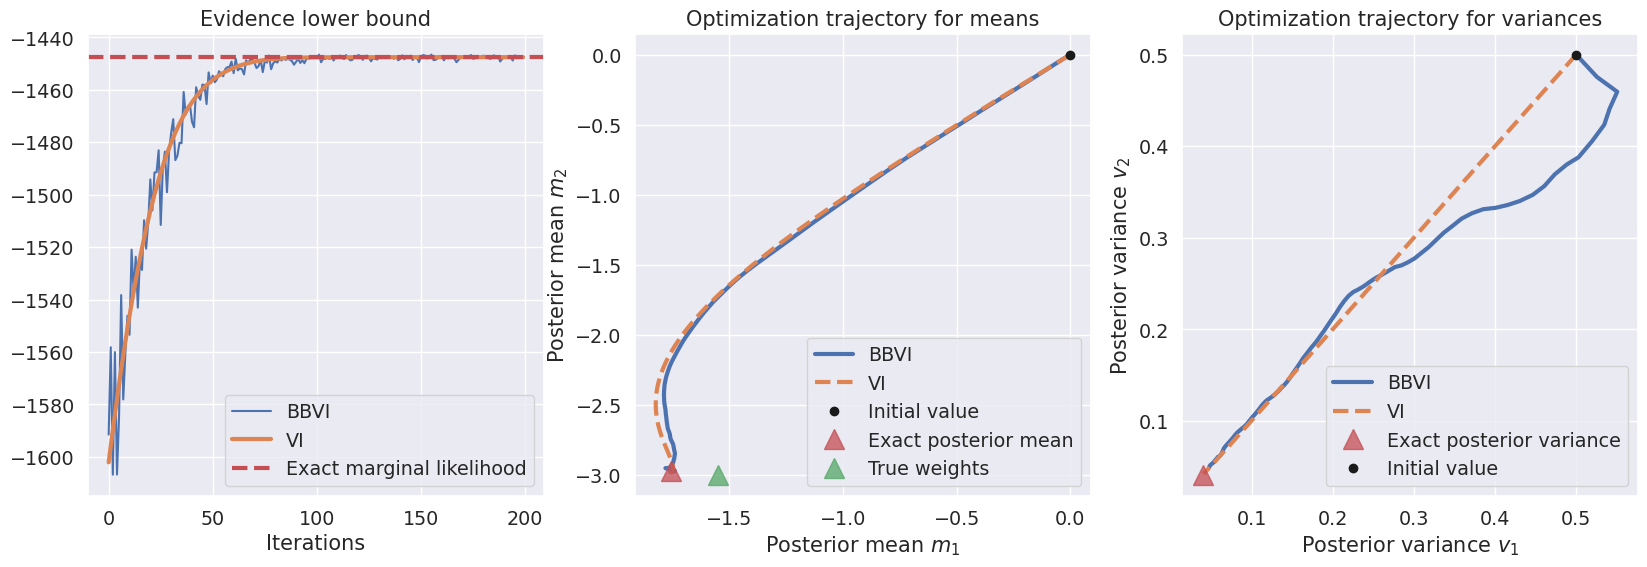

In [7]:
# settings
num_params = X.shape[1]
max_itt = 200
step_size = 5e-2
num_samples = 7
batch_size = None

# fit approximations
vi = VariationalInference(num_params, step_size, max_itt).fit(X, y)
bbvi = BlackBoxVariationalInference(log_prior_pdf, log_lik_linreg, num_params, step_size, max_itt, num_samples, batch_size).fit(X, y)

# plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].plot(bbvi.ELBO_history, color=colors[0], label='BBVI')
axes[0].plot(vi.ELBO_history, linewidth=3, color=colors[1], label='VI')
axes[0].axhline(exact_marginal, color='r', linestyle='--', label='Exact marginal likelihood', linewidth=3)
axes[0].set(title='Evidence lower bound', xlabel='Iterations')
axes[0].legend()

axes[1].plot(bbvi.m_history[:, 0], bbvi.m_history[:, 1], '-', color=colors[0], label='BBVI', linewidth=3)
axes[1].plot(vi.m_history[:, 0], vi.m_history[:, 1], '--', color=colors[1], label='VI', linewidth=3)
axes[1].plot(vi.m_history[0, 0], vi.m_history[0, 1], 'ko', label='Initial value')

axes[1].plot(m_true[0], m_true[1], 'r^', label='Exact posterior mean', markersize=15, alpha=0.75)
axes[1].plot(w_true[0], w_true[1], 'g^', label='True weights', markersize=15, alpha=0.75)
axes[1].set(xlabel='Posterior mean $m_1$', ylabel='Posterior mean $m_2$', title='Optimization trajectory for means')

axes[2].plot(bbvi.v_history[:, 0], bbvi.v_history[:, 1], '-', color=colors[0], label='BBVI', linewidth=3)
axes[2].plot(vi.v_history[:, 0], vi.v_history[:, 1], '--', color=colors[1], label='VI', linewidth=3)
axes[2].plot(S_true[0,0], S_true[1,1], 'r^', label='Exact posterior variance', markersize=15, alpha=0.75)
axes[2].plot(vi.v_history[0, 0], vi.v_history[0, 1], 'ko', label='Initial value')
axes[2].set(xlabel='Posterior variance $v_1$', ylabel='Posterior variance $v_2$', title='Optimization trajectory for variances')

for i in range(3):
    axes.flat[i].legend()

print(60*'-')
print('VI')
print(60*'-')
print('Relative error for the posterior mean: %4.3e' % relative_error(vi.m, m_true))
print('Relative error for the posterior variances: %4.3e' % relative_error(vi.v, jnp.diag(S_true)))
print('\n')

print(60*'-')
print('BBVI')
print(60*'-')
print('Relative error for the posterior mean: %4.3e' % relative_error(bbvi.m, m_true))
print('Relative error for the posterior variances: %4.3e' % relative_error(bbvi.v, jnp.diag(S_true)))


**Task 4.2**: Explain the difference between the true weights, the exact posterior mean, and the approximate posterior mean. [**Discussion question**]

**Task 4.3**: Experiment with different numbers of MC samples by changing the *num_samples* parameter, e.g. try *num_samples*$ = 1, 10, 100$ etc. for BBVI. What happens? [**Discussion question**]

**Task 4.4**: Fix the number of samples to *num_samples*$ = 20$ and experiment with *batch_size*$ = \text{None}, 1, 10, 100$. What happens? Increase the number of iterations if needed. [**Discussion question**]


# Part 5:  Spam vs ham detection

In this part, we will build a simple spam vs ham (not spam) classifier based on a dataset of SMS messages. We'll see how BBVI can be extremely useful when prototyping different models.

First, we will load the dataset:

In [8]:
# load data
data = jnp.load('./sms_data.npz')
train_texts = data['train_texts']
test_texts = data['test_texts']
y_train = data['train_targets']
y_test = data['test_targets']
labels = data['labels']

# find spam and ham examples
spam_idx = jnp.where(y_train == 1)[0]
ham_idx = jnp.where(y_test == 0)[0]

# print a few examples
key = random.PRNGKey(1)
key1, key2 = random.split(key)

print('Spam:')
for n in random.choice(key1, spam_idx, shape=(10,), replace=False):
    print(train_texts[n])
print('')
print('Ham:')
for n in random.choice(key2, ham_idx, shape=(10,), replace=False):
    print(train_texts[n])

Spam:
thesmszone.com lets you send free anonymous and masked messages..im sending this message from there..do you see the potential for abuse???
you've won tkts to the euro2004 cup final or £800 cash, to collect call 09058099801 b4190604, pobox 7876150ppm
hot live fantasies call now 08707500020 just 20p per min ntt ltd, po box 1327 croydon cr9 5wb 0870 is a national rate call
i don't know u and u don't know me. send chat to 86688 now and let's find each other! only 150p/msg rcvd. hg/suite342/2lands/row/w1j6hl ldn. 18 years or over.
urgent! your mobile no 077xxx won a £2,000 bonus caller prize on 02/06/03! this is the 2nd attempt to reach you! call 09066362206 asap! box97n7qp, 150ppm
loans for any purpose even if you have bad credit! tenants welcome. call noworriesloans.com on 08717111821
sms services. for your inclusive text credits, pls goto www.comuk.net login= 3qxj9 unsubscribe with stop, no extra charge. help 08702840625.comuk. 220-cm2 9ae
wamma get laid?want real doggin locations 

Again, we will rely on *transfer learning* to predict the label of each text. First, we have used a pretrained FastText model to compute 300-dimensional embedding for each text. Afterwards, we have reduced the dimensionality to $D = 15$ (to speed up the computations). The FastText method is not part of the curriculum of this course, but if you are curiuos, you can read more about it here: [https://fasttext.cc/docs/en/crawl-vectors.html](https://fasttext.cc/docs/en/crawl-vectors.html).

As a result, we have a $D = 15$ vector representing each text. Let's inspect the first two components visually:

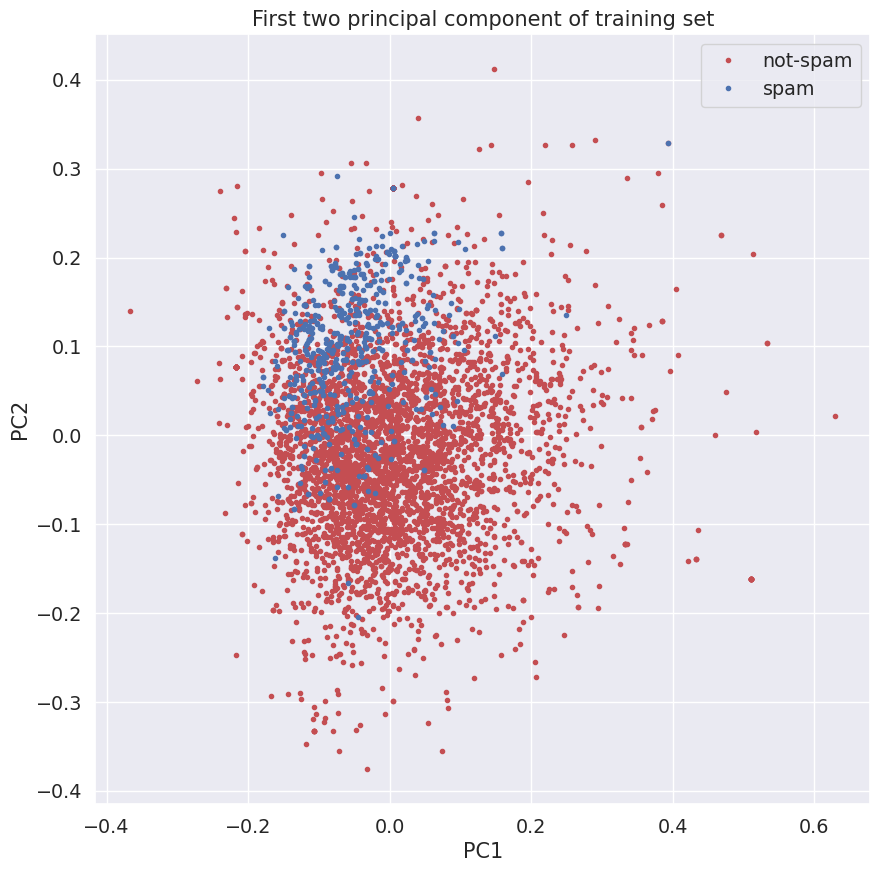

In [9]:
x_train = data['ztrain'] # embeddings for training set
x_test = data['ztest']   # embeddings for test set

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(x_train[y_train == 0, 0], x_train[y_train==0, 1], 'r.', label=labels[0])
ax.plot(x_train[y_train == 1, 0], x_train[y_train==1, 1], 'b.', label=labels[1])
ax.set(xlabel='PC1', ylabel='PC2', title='First two principal component of training set')
ax.legend();

Let's now consider the model
\begin{align*}
    p(\mathbf{y}, \mathbf{w}) = \prod_{n=1}^N p(y_n|\mathbf{x}_n, \mathbf{w})p(\mathbf{w})=  \prod_{n=1}^N p(y_n|\mathbf{x}_n, \mathbf{w})\mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1} \mathbf{I})\tag{15}
\end{align*}

where $y_n \in \left\lbrace 0, 1 \right\rbrace$ is the label of the $n$-th text, $\mathbf{x}_n \in \mathbb{R}^{D}$ is the PCA features representation of each text, $p(y_n|\mathbf{x}_n, \mathbf{w})$ is the likeliood for the $n$-th observation and $p(\mathbf{w})$ is a Gaussian prior on the weights. 

We will explore and compare three different likelihoods for binary classification:

**Likelihood 1**: Standard Bernoulli distribution with a logistic sigmoid as inverse link function

\begin{align*}
    p(y_n|\mathbf{w}, \mathbf{x}_n) = \text{Ber}\left(y_n|\sigma(\mathbf{w}^T\mathbf{x}_n)\right) \tag{16}
\end{align*}

**Likelihood 2**: Standard Bernoulli distribution with a Probit function $\mathbf{\Phi}$ (CDF of standarized normal distribution) as inverse link function

\begin{align*}
    p(y_n|\mathbf{w}, \mathbf{x}_n) = \text{Ber}\left(y_n|\Phi(\mathbf{w}^T\mathbf{x}_n)\right) \tag{16}
\end{align*}

**Likelihood 3**: Robust likelihood with noisy labels

The third likelihood we consider is a so-called *robust likelihood* that assumes a fraction of the training labels are mislabelled (e.g. samples that are actually spam are labelled as non-spam and vice versa), which can make the model more robust to outliers etc.

Here we assume that a given training example, i.e. $y_i$, is mislabelled with probability $\epsilon \in \left\lbrace 0, 1\right\rbrace$. Let $e_i \in \left\lbrace 0,1 \right\rbrace$ be $1$ if $y_i$ is mislabelled and otherwise $e_i = 0$. 

\begin{align*}
    p(y_i|\mathbf{w}, \mathbf{x}_i, e_i) &=    \text{Ber}\left(y_i|(1-e_i)\sigma(\mathbf{w}^T\mathbf{x}_i) + e_i\sigma(-\mathbf{w}^T\mathbf{x}_i)\right)\\
    p(e_i) &= \text{Ber}(e_i|\epsilon) 
\end{align*}

Finally, we can use the sum rule to marginalize out $e_i$:

\begin{align*}
p(y_i|\mathbf{w}, \mathbf{x}_i) &= \sum_{e_i} p(y_i|\mathbf{w}, \mathbf{x}_i, e_i) p(e_i)\\
%
&= (1-\epsilon)\text{Ber}\left(y_i|\sigma(\mathbf{w}^T\mathbf{x}_i)\right) + \epsilon \text{Ber}\left(y_i|\sigma(-\mathbf{w}^T\mathbf{x}_i)\right)
\end{align*}

Hence, this likelihood has an additional parameters $\epsilon \in \left[0, 1\right]$


We will now let $f = \mathbf{w}^T \mathbf{z}$ and plot likelihoods and log likelihoods for observing $y = 1$ for each the three likelihoods for $f \in \left[-10, 10\right]$. Use $\epsilon = 0.05$ for the robust model:

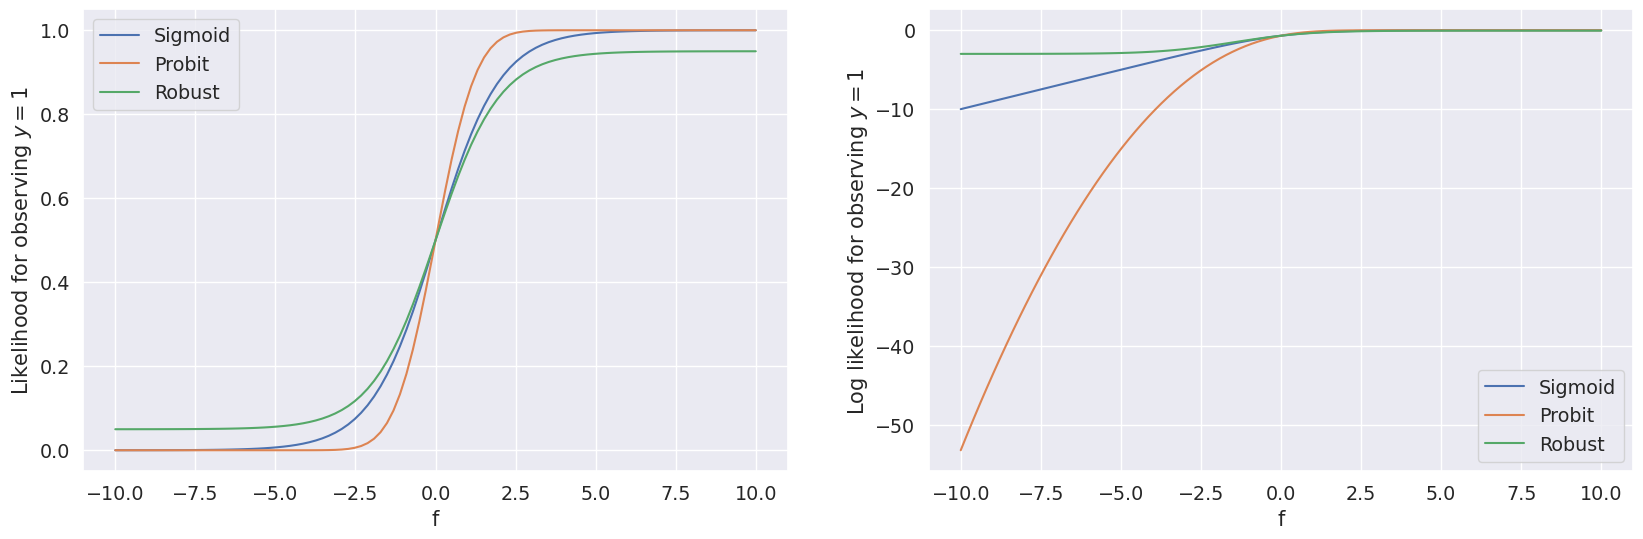

In [10]:
# likelihoods
phi = lambda f: norm.cdf(f)
sigmoid = lambda f: 1/(1+jnp.exp(-f))
robust_sigmoid = lambda f, epsilon: (1-epsilon)*sigmoid(f) + epsilon*sigmoid(-f) 

# array for f
f = jnp.linspace(-10, 10, 100)

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot(f, sigmoid(f), label='Sigmoid')
ax[0].plot(f, phi(f), label='Probit')
ax[0].plot(f, robust_sigmoid(f, 0.05), label='Robust')
ax[0].legend()
ax[0].set(ylabel='Likelihood for observing $y=1$', xlabel='f')

ax[1].plot(f, jnp.log(sigmoid(f)), label='Sigmoid')
ax[1].plot(f, jnp.log(phi(f)), label='Probit')
ax[1].plot(f, jnp.log(robust_sigmoid(f, 0.05)), label='Robust')
ax[1].legend()
ax[1].set(ylabel='Log likelihood for observing $y=1$', xlabel='f');

**Task 5.1**: Study the plots and comment on to which degree each of the three likelihoods penalize outliers. [**Discussion question**]



# Part 6:  Prototyping and testing models using BBVI

The goal of this part is to implement all three models. We will start with the "standard" Bayesian logistic regression model with a Gaussian prior:

In [11]:
from jax.scipy.special import logsumexp

log_bernoulli_logit = lambda x, z: (1-x)*jnp.log(1-sigmoid(z)) + x*jnp.log(sigmoid(z))

def log_lik1(X, y, w):
    """
    Implements the log likelihood function for the logistic regression model with the sigmoid as inverse link function.
    S is number of MC samples, N is number of datapoints in likelihood and D is the dimensionality of the model

    Inputs:
    X              -- Design matrix (np.array of size N x D)
    y              -- vector of target (np.array of size N)
    w              -- Matrix of weights (np.array of size S x D)

    outputs:
    log_likelihood -- Array of log likelihood for each sample in w (np.array of size S)
     """

    # compute linear part (dim: S x N)
    f = w @ X.T

    # compute logits (dim: S x N)
    logits = log_bernoulli_logit(y, f)

    # sum across data points (dim: S)
    log_likelihood = jnp.sum(logits, axis=1)   

    return log_likelihood

def predictive_model1(z, w_samples):
    return jnp.mean(sigmoid(w_samples@z.T), axis=0)

# settings
num_params = 15
max_itt = 2000
step_size = 5e-2
num_samples = 20
batch_size = 200

# set prior 
log_prior = lambda w: log_prior_pdf(w, 100.)

# fit approximations
bbvi1 = BlackBoxVariationalInference(log_prior, log_lik1, num_params, step_size, max_itt, num_samples, batch_size, verbose=True)
bbvi1.fit(x_train, y_train);


Fitting approximation using Black-box VI
	Itt:   249, ELBO = -2800.14
	Itt:   499, ELBO = -2731.90
	Itt:   749, ELBO = -2717.87
	Itt:   999, ELBO = -2730.70
	Itt:  1249, ELBO = -2713.99
	Itt:  1499, ELBO = -2723.34
	Itt:  1749, ELBO = -2702.01
	Itt:  1999, ELBO = -2719.91
	Optimization done in 44.27s



And let's compute the accuracy and $F_1$-score ([$F_1$ scores on wiki](https://en.wikipedia.org/wiki/F-score)):

In [12]:
def compute_accuracy(prob, y):
    # predict
    yhat = 1.0 * (prob > 0.5)
    # compute accuracy
    return jnp.mean(yhat.ravel() == y.ravel())

def compute_f1(prob, y):
    # predict
    yhat = 1.0 * (prob > 0.5)
    # evaluate precision/recall for f1
    tp = jnp.logical_and(yhat == 1, y == 1).sum()
    fp = jnp.logical_and(yhat == 1, y == 0).sum()
    fn = jnp.logical_and(yhat == 0, y == 1).sum()
    precision, recall = tp/(tp+fp), tp/(tp+fn)
    # compute f1
    return 2* (precision*recall)/(precision+recall)

key = random.PRNGKey(123)
w1_samples = bbvi1.generate_posterior_samples(key)
p1_test = predictive_model1(x_test, w1_samples)

print(f'M1: Test  accuracy = {compute_accuracy(p1_test, y_test):3.2f}, Test  F1 = {compute_f1(p1_test, y_test):3.2f}')

M1: Test  accuracy = 0.72, Test  F1 = 0.50


**Task 6.1**: Implement the probit regression model. Fit the model using BBVI and compute the test metrics

*Hints*:
- remember to both implement the log joint and the function for the evaluating predictive distribution

**Solution**

In [13]:
log_phi = lambda f: norm.logcdf(f)
log_bernoulli_probit = lambda x, z: (1-x)*jnp.log(1-phi(z)) + x*log_phi(z)

def log_lik2(X, y, w):

    # compute linear part (dim: S x N)
    f = w @ X.T

    # compute log probits (dim: S x N)
    log_probits = log_bernoulli_probit(y, f)
    log_likelihood = jnp.sum(log_probits, axis=1)   # (dim: S)

    return log_likelihood

def predictive_model2(z, w_samples):
    return jnp.mean(phi(w_samples@z.T), axis=0)

bbvi2 = BlackBoxVariationalInference(log_prior_pdf, log_lik2, num_params, step_size, max_itt, num_samples, batch_size,  verbose=True)
bbvi2.fit(x_train, y_train);



Fitting approximation using Black-box VI
	Itt:   249, ELBO = -2773.14
	Itt:   499, ELBO = -2738.00
	Itt:   749, ELBO = -2725.10
	Itt:   999, ELBO = -2736.64
	Itt:  1249, ELBO = -2721.35
	Itt:  1499, ELBO = -2730.15
	Itt:  1749, ELBO = -2710.83
	Itt:  1999, ELBO = -2726.80
	Optimization done in 74.24s



In [14]:
key = random.PRNGKey(1234)
w2_samples = bbvi2.generate_posterior_samples(key)
p2_test = predictive_model2(x_test, w2_samples)

print(f'M2: Test  accuracy = {compute_accuracy(p2_test, y_test):3.2f}, Test  F1 = {compute_f1(p2_test, y_test):3.2f}')

M2: Test  accuracy = 0.72, Test  F1 = 0.50


**End of solution**

**Task 6.2**: Implement the robust classification model for $\epsilon = 0.05$ and evaluate the test metrics

**Solution**

In [15]:
def log_lik3(X, y, w, epsilon=0.05):
    
    # compute linear part (dim: S x N)
    f = w @ X.T

    # compute logits (S x N)
    logits1 = jnp.log(1 - epsilon) + log_bernoulli_logit(y, f)
    logits2 = jnp.log(epsilon) + log_bernoulli_logit(y, -f)
    logits = logsumexp(jnp.stack((logits1, logits2)), axis=0)

    # sum across data points    # (dim: S)
    log_likelihood = jnp.sum(logits, axis=1)

    return log_likelihood

def predictive_model3(z, w_samples, epsilon=0.05):
    f = w_samples@z.T
    s1 = sigmoid(f)
    return jnp.mean((1-epsilon)*s1 + epsilon*(1-s1), axis=0)


bbvi3 = BlackBoxVariationalInference(log_prior_pdf, log_lik3, num_params, step_size, max_itt, num_samples, batch_size, verbose=True)
bbvi3.fit(x_train, y_train);

Fitting approximation using Black-box VI
	Itt:   249, ELBO = -2789.75
	Itt:   499, ELBO = -2696.23
	Itt:   749, ELBO = -2668.63
	Itt:   999, ELBO = -2660.39
	Itt:  1249, ELBO = -2633.42
	Itt:  1499, ELBO = -2638.91
	Itt:  1749, ELBO = -2611.83
	Itt:  1999, ELBO = -2631.77
	Optimization done in 82.89s



In [16]:
key = random.PRNGKey(123)
w3_samples = bbvi3.generate_posterior_samples(key)
p3_test = predictive_model3(x_test, w3_samples)
print(f'M3: Test  accuracy = {compute_accuracy(p3_test, y_test):3.2f}, Test  F1 = {compute_f1(p3_test, y_test):3.2f}')


M3: Test  accuracy = 0.75, Test  F1 = 0.52


**Task 6.3**: Plot and compare the optimization trajectories for the ELBOs of the three models. Does the model seems to have converged? How does the ELBO values compare to the predictive performance for each of the models?

*Hints*: 
- Use *scipy.ndimage.filters import uniform_filter1d* or something similar to smoothen the ELBOs before plotting, (e.g plot uniform_filter1d(bbvi1.ELBO_history, 100))


**Solution**

/tmp/ipykernel_52442/1436514573.py:1: DeprecationWarning: Please import `uniform_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import uniform_filter1d


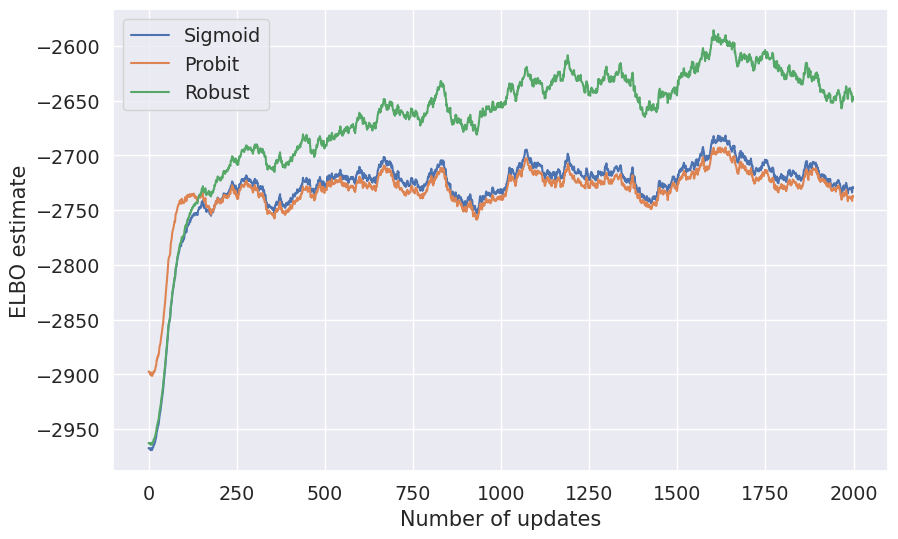

In [17]:
from scipy.ndimage.filters import uniform_filter1d

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(uniform_filter1d(bbvi1.ELBO_history, 100), label='Sigmoid')
ax.plot(uniform_filter1d(bbvi2.ELBO_history, 100), label='Probit')
ax.plot(uniform_filter1d(bbvi3.ELBO_history, 100), label='Robust')
ax.legend()
ax.set(xlabel='Number of updates', ylabel='ELBO estimate');

**End of solution**

In this exercise, we assumed $\epsilon = 0.05$. In practice, one could learn this way by either simply optimizing the ELBO wrt. $\epsilon$ (corresponding to a marginal likelihood estimate). A more Bayesian approach would be to impose a Beta-prior distribution on $\epsilon$ and compute the posterior distribution using BBVI as well. Furthermore, it is possible to get much better performance in this dataset, but the purpose of the exercise is to learn BBVI and see how easy it is to prototype different models.

**Task 6.4**: Suppose we decided to augment the model with a prior distribution for $\epsilon \in \left[0, 1\right]$, e.g. $p(\epsilon) = \text{Beta}(\epsilon|a,b)$. How would you adapt the variational family?

**Hints**: What is the support a mean-field Gaussian distribution?


**Solution**

Gaussian distributions have support on the entire real line, but $\epsilon \in \left[0, 1\right]$ is a probability and therefore a number in the unit interval. Naively augmenting the variational family to $q(\mathbf{w}, \epsilon) = \left[\prod_{i=1}^D \mathcal{N}(w_i|m_i, v_i)\right] \mathcal{N}(\epsilon|\mu, \tau)$ would  therefore be a bad idea. Instead, we could consider one of the two solutions: 1) either make a change of variable to make the support of the distributions compatible, e.g. $\tilde{\epsilon} = \sigma^{-1}(\epsilon) \in \mathbb{R}$ (where $\sigma(\cdot)$ is the logistic sigmoid function) and impose a mean-field Gaussian over $\tilde{\epsilon}$, which is now a real number or 2) Use a variational family of the form $q(\mathbf{w}, \epsilon) = \left[\prod_{i=1}^D \mathcal{N}(w_i|m_i, v_i)\right] \text{Beta}(\epsilon|\tilde{a}, \tilde{b})$. The drawback of the latter is that we have to adapt our code accordingly.

**End of solution**